In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Cause plots to be displayed in the notebook:
%pylab inline
%matplotlib inline

# Override default figure sizing:
#pylab.rcParams['figure.figsize'] = (10, 6)
sns.set(color_codes = True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
missing_values=["n/a","na","--","?"]
df=pd.read_csv('../../dataproject/train.csv', na_values=missing_values)
#dftest=pd.read_csv('../../dataproject/test.csv', na_values=missing_values)

In [3]:
df['date']=pd.to_datetime(df['date'])

## Time serie for store 1 item 1

In [4]:
df_store1 =df[(df['store']==1)&(df['item']==1)]
#df_store1

In [6]:
timeseries_columns = ['date','sales']
ts_store1=df_store1[timeseries_columns]
ts_store1=ts_store1.set_index('date')
ts_store1

,sales
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10
...,...
2017-12-27,14
2017-12-28,19
2017-12-29,15


In [6]:
#sum(ts_store1.isnull().sum())

In [37]:
#ts_store1.plot()

Text(0, 0.5, 'sales')

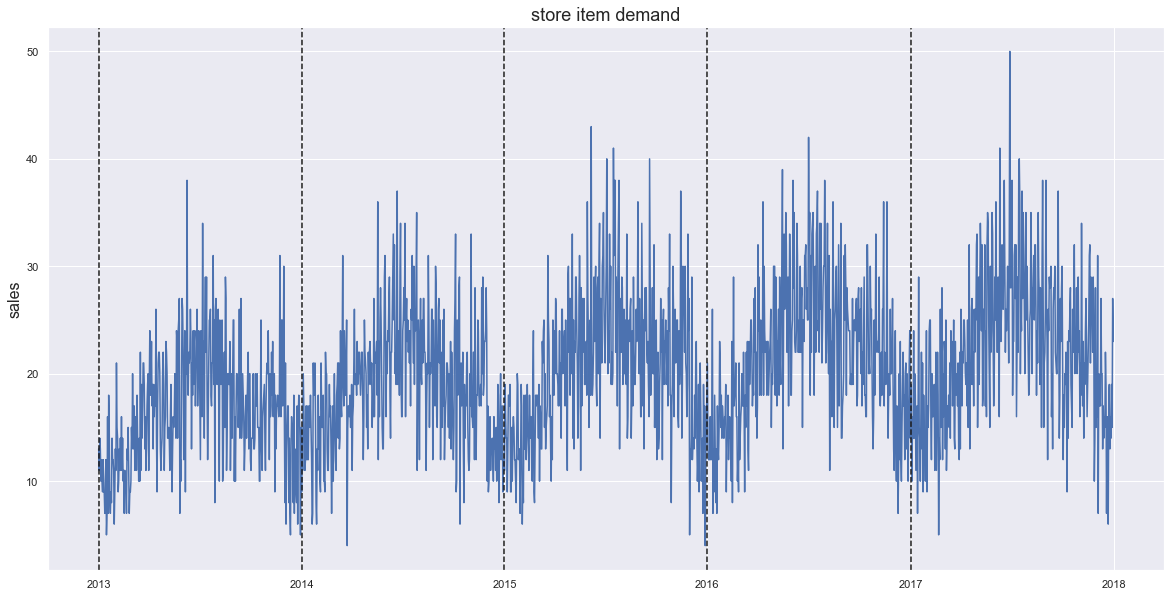

In [8]:
plt.figure(figsize = (20,10))
plt.plot(ts_store1)
for year in range(2013,2018):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--')
plt.title('store item demand', fontsize = 18)
plt.ylabel('sales', fontsize = 16)

### Split Train/Test

In [25]:
train = ts_store1.iloc[:len(ts_store1)-92] 
test = ts_store1.iloc[len(ts_store1)-92:] # set 3 months(92 days)) for testing

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

### SARIMAX with Fourier Terms and exogenus for holidays and items over 25

Utilize exogenous variables in SARIMAX to model additional seasonalities with Fourier terms. yearly season equals 365.25 to account for leap years.
The seasonal pattern is modeled through the addition of Fourier terms which are used as external regressors. This approach is flexible, allowing to incorporate multiple periods. Each seasonality is modeled by a trigonometric representation based on Fourier series

Weekly pattern with seasonal of sarima and yearly pattern with 2 furier terms as exogenous variable

In [15]:
#ts_store1_fourier=ts_store1.copy()

In [17]:
#ts_store1_fourier

In [7]:
# prepare Fourier terms for yearly seasonality pattern
ts_store1['sin365'] = np.sin(2 * np.pi * ts_store1.index.dayofyear / 365.25)
ts_store1['cos365'] = np.cos(2 * np.pi * ts_store1.index.dayofyear / 365.25)
ts_store1['sin365_2'] = np.sin(4 * np.pi * ts_store1.index.dayofyear / 365.25)
ts_store1['cos365_2'] = np.cos(4 * np.pi * ts_store1.index.dayofyear / 365.25)

In [15]:
ts_store1.tail(100)

,sales,sin365,cos365,sin365_2,cos365_2,y_25
date,,,,,,
2017-09-23,37,-0.990692,-0.136120,0.269707,-0.962943,1
2017-09-24,24,-0.992887,-0.119059,0.236424,-0.971650,0
2017-09-25,14,-0.994788,-0.101962,0.202861,-0.979208,0
2017-09-26,18,-0.996395,-0.084835,0.169058,-0.985606,0
2017-09-27,27,-0.997707,-0.067683,0.135055,-0.990838,1
...,...,...,...,...,...,...
2017-12-27,14,-0.073045,0.997329,-0.145700,0.989329,0
2017-12-28,19,-0.055879,0.998438,-0.111583,0.993755,0
2017-12-29,15,-0.038696,0.999251,-0.077334,0.997005,0


In [14]:
## EXOGENOUS FOR ITEMS MORE THAN 25
def y_more25(sales):
    #date = pd.to_datetime(ds)
    if sales >25:
        return 1
    else:
        return 0
ts_store1['y_25'] = ts_store1['sales'].apply(y_more25)

In [26]:
playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'date' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'noholidays' : 0,
  'holidays' : 2}
)
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'date': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25','2018-01-01','2018-01-15','2018-02-14','2018-02-19'
                       ]),
  'noholidays': 0,
  'holidays': 3,
})

holidays = pd.concat((playoffs, superbowls))

In [28]:
holidays.set_index('date')

,holiday,noholidays,holidays
date,,,
2013-01-12,playoff,0,2
2013-07-12,playoff,0,2
2013-12-24,playoff,0,2
2014-01-12,playoff,0,2
2014-07-12,playoff,0,2
...,...,...,...
2017-12-25,superbowl,0,3
2018-01-01,superbowl,0,3
2018-01-15,superbowl,0,3


In [29]:
ts_store1=pd.merge(ts_store1,holidays,how='left', on=['date'])

In [36]:
ts_store1.drop(['holiday'],axis=1, inplace=True)

In [39]:
ts_store1= ts_store1.fillna(0)

In [44]:
ts_store1

,sales,sin365,cos365,sin365_2,cos365_2,y_25,noholidays,holidays
date,,,,,,,,
2013-01-01,13,0.017202,0.999852,0.034398,0.999408,0,0.0,3.0
2013-01-02,11,0.034398,0.999408,0.068755,0.997634,0,0.0,0.0
2013-01-03,14,0.051584,0.998669,0.103031,0.994678,0,0.0,0.0
2013-01-04,13,0.068755,0.997634,0.137185,0.990545,0,0.0,0.0
2013-01-05,10,0.085906,0.996303,0.171177,0.985240,0,0.0,0.0
...,...,...,...,...,...,...,...,...
2017-12-27,14,-0.073045,0.997329,-0.145700,0.989329,0,0.0,0.0
2017-12-28,19,-0.055879,0.998438,-0.111583,0.993755,0,0.0,0.0
2017-12-29,15,-0.038696,0.999251,-0.077334,0.997005,0,0.0,0.0


In [43]:
ts_store1=ts_store1.set_index('date')

In [45]:
train = ts_store1.iloc[:(len(ts_store1)-92)]['sales']
test= ts_store1.iloc[(len(ts_store1)-92):]['sales']
exog_train = ts_store1.drop(['sales'], axis = 1)[:len(ts_store1)-92]
exog_test = ts_store1.drop(['sales'], axis = 1)[len(ts_store1)-92:]

In [13]:
#train_fourier

In [80]:
#test

In [48]:
exog_train

,sin365,cos365,sin365_2,cos365_2,y_25,noholidays,holidays
date,,,,,,,
2013-01-01,0.017202,0.999852,0.034398,0.999408,0,0.0,3.0
2013-01-02,0.034398,0.999408,0.068755,0.997634,0,0.0,0.0
2013-01-03,0.051584,0.998669,0.103031,0.994678,0,0.0,0.0
2013-01-04,0.068755,0.997634,0.137185,0.990545,0,0.0,0.0
2013-01-05,0.085906,0.996303,0.171177,0.985240,0,0.0,0.0
...,...,...,...,...,...,...,...
2017-09-26,-0.996395,-0.084835,0.169058,-0.985606,0,0.0,0.0
2017-09-27,-0.997707,-0.067683,0.135055,-0.990838,1,0.0,0.0
2017-09-28,-0.998724,-0.050511,0.100892,-0.994897,0,0.0,0.0


In [54]:
exog_test

,sin365,cos365,sin365_2,cos365_2,y_25,noholidays,holidays
date,,,,,,,
2017-10-01,-0.999999,0.001075,-0.002150,-0.999998,0,0.0,0.0
2017-10-02,-0.999833,0.018277,-0.036547,-0.999332,0,0.0,0.0
2017-10-03,-0.999371,0.035473,-0.070900,-0.997483,0,0.0,0.0
2017-10-04,-0.998613,0.052658,-0.105170,-0.994454,0,0.0,0.0
2017-10-05,-0.997559,0.069828,-0.139315,-0.990248,0,0.0,0.0
...,...,...,...,...,...,...,...
2017-12-27,-0.073045,0.997329,-0.145700,0.989329,0,0.0,0.0
2017-12-28,-0.055879,0.998438,-0.111583,0.993755,0,0.0,0.0
2017-12-29,-0.038696,0.999251,-0.077334,0.997005,0,0.0,0.0


order = (6,1,1), seasonal_order = (1,0,2,7)

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
model_exog1 = SARIMAX(train, order = (6,1,5), seasonal_order = (1,0,2,7), 
                exog = exog_train, 
                enforce_stationary = False, 
                enforce_invertibility = False).fit() 
                #freq = 'D').fit()

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [50]:
predict_exog1 = model_exog1.forecast(steps=92,exog=exog_test)

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [86]:
test

date
2017-10-01    21
2017-10-02    12
2017-10-03    18
2017-10-04    15
2017-10-05    20
              ..
2017-12-27    14
2017-12-28    19
2017-12-29    15
2017-12-30    27
2017-12-31    23
Name: sales, Length: 92, dtype: int64

In [67]:
predict_exog1.values

array([21.05404742, 17.50765586, 18.37212639, 19.16141935, 19.59540245,
       19.68911547, 21.17681698, 20.42468499, 16.32378206, 18.42346612,
       18.79953047, 19.07767864, 19.69508359, 28.89909406, 28.24995725,
       17.02542543, 17.91775631, 18.49087884, 27.23033734, 19.14760882,
       28.57192372, 28.02519845, 16.51503235, 17.68245225, 18.24883575,
       26.69716153, 18.90504311, 19.95754452, 27.48568828, 16.33011589,
       17.34272776, 17.76514729, 18.20186093, 18.49693521, 27.73549373,
       18.96203264, 15.93874476, 16.92916789, 17.52486547, 17.74958616,
       17.32293545, 19.16792129, 26.75128308, 15.60415623, 16.6596387 ,
       17.06565879, 17.4010348 , 17.77094667, 26.95018258, 26.40644074,
       15.31535454, 24.50098549, 25.03474011, 16.2943659 , 17.33413226,
       26.62713227, 17.76418221, 14.94666983, 15.96318252, 24.68259553,
       16.67833082, 17.0523605 , 17.96953826, 25.66665215, 14.7172309 ,
       15.62762237, 16.09517216, 16.41980131, 16.70456207, 25.92

In [85]:
j = pd.DataFrame(test)
k = pd.DataFrame(predict_exog1)
k.set_index(test.index, inplace = True)
comparetest = pd.concat([j,k],axis = 1)
comparetest.columns = ['Actual', 'Predict']
comparetest.head()

,Actual,Predict
date,,
2017-10-01,21,21.054047
2017-10-02,12,17.507656
2017-10-03,18,18.372126
2017-10-04,15,19.161419
2017-10-05,20,19.595402


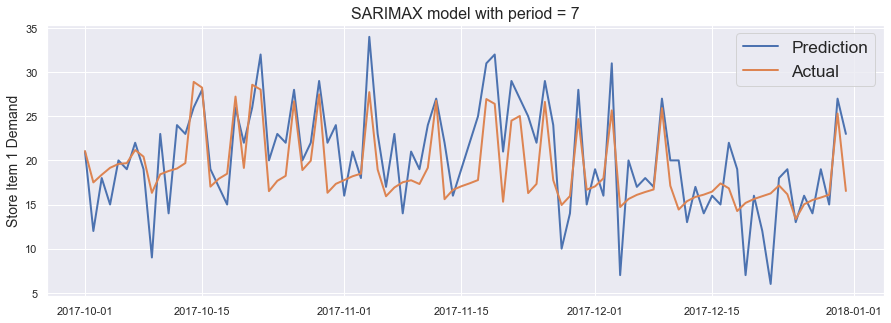

In [89]:
plt.figure(figsize = (15,5))
plt.plot(comparetest['Actual'], linewidth = 2)
plt.plot(comparetest['Predict'], linewidth = 2)
plt.title('SARIMAX model with period = 7', fontsize = 16)
plt.ylabel('Store Item 1 Demand', fontsize = 14)
plt.legend(['Prediction', 'Actual'], fontsize = 'x-large')
#plt.savefig('SARIMA_365.png')
plt.show()

In [90]:
print('SARIMAX: Includes Both Weekly and Yearly Seasonality and regressors (6,1,1), seasonal_order = (1,0,2,7)')
regPrintErr(test.values, predict_exog1.values)

SARIMAX: Includes Both Weekly and Yearly Seasonality and regressors (6,1,1), seasonal_order = (1,0,2,7)
R2 Score: 0.5436711207639586
MAPE: 17.858745401663924
RMSE: 3.934021541587709


### order = (4,1,1), seasonal_order = (1,0,2,7)

In [73]:
model_exog2 = SARIMAX(train, order = (4,1,1), seasonal_order = (1,0,2,7), 
                exog = exog_train, 
                enforce_stationary = False, 
                enforce_invertibility = False).fit()

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [74]:
predict_exog2 = model_exog2.forecast(steps=92,exog=exog_test)

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


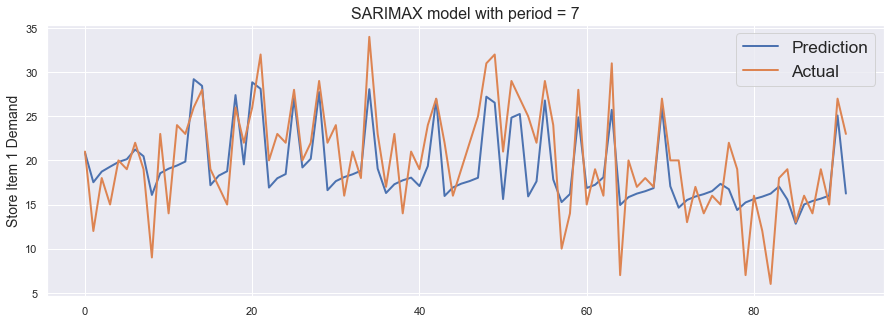

In [75]:
plt.figure(figsize = (15,5))
plt.plot(predict_exog2.values, linewidth = 2)
plt.plot(test.values, linewidth = 2)
plt.title('SARIMAX model with period = 7', fontsize = 16)
plt.ylabel('Store Item 1 Demand', fontsize = 14)
plt.legend(['Prediction', 'Actual'], fontsize = 'x-large')
#plt.savefig('SARIMA_365.png')
plt.show()

In [77]:
print('SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)')
regPrintErr(test.values, predict_exog2.values)

SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)
R2 Score: 0.5555121265218265
MAPE: 17.76072538477223
RMSE: 3.8826452794294246


### Walk-Forward Validation

In [92]:
# walk-forward validation
history = [x for x in train]
exog_hist = exog_train.copy()
predictions2 = list()

for i in range(len(test)):
    # predict
    model2 = SARIMAX(history, order = (4,1,1), seasonal_order = (1,0,2,7), 
                exog = exog_hist, 
                enforce_stationary = False, 
                enforce_invertibility = False, 
                )
    model_fit = model2.fit()
    yhat = model_fit.forecast(exog = exog_test.iloc[i,:]) #Forecasting the next step
    predictions2.append(yhat)
    # observation
    obs = test[i]    #Actual data on this day
    history.append(obs)
    exog_hist = exog_hist.append(exog_test.iloc[i,:])

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

In [93]:
predictions_complete2 = pd.Series()
for i in predictions2:
    predictions_complete2 = predictions_complete2.append(i)

<ipython-input-93-2cea6f3a682f>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_complete2 = pd.Series()


In [94]:
predictions_complete2.to_csv('SARIMAX_WALKFORWARD_withexogenus_411_1027.csv')
#predictions_complete2 = pd.read_csv('SARIMAX_WALKFORWARD_411.csv')
#predict_365.columns = ['date', 'predict']
#predict_365['date'] = pd.to_datetime(predict_365['date'])
#predict_365.set_index('date', inplace = True)
#predict_365.head()

In [95]:
c = pd.DataFrame(test)
d = pd.DataFrame(predictions_complete2)
d.set_index(test.index, inplace = True)
compare2 = pd.concat([c,d],axis = 1)
compare2.columns = ['Actual2', 'Predict2']
compare2.head()

,Actual2,Predict2
date,,
2017-10-01,21,20.873390
2017-10-02,12,17.501732
2017-10-03,18,18.505962
2017-10-04,15,18.889692
2017-10-05,20,19.353821


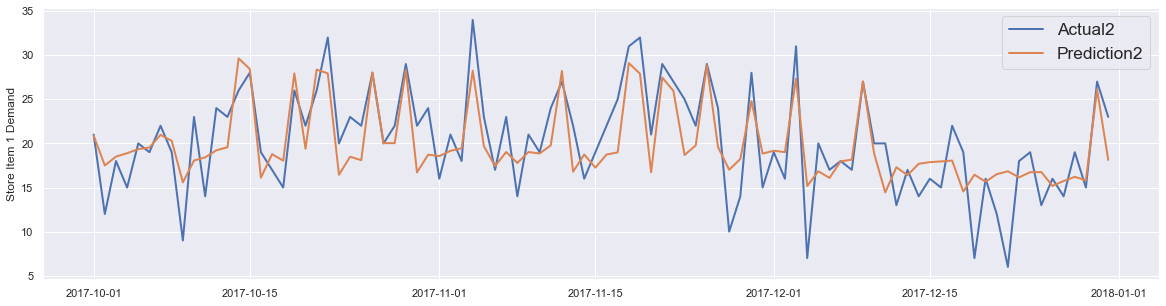

In [96]:
plt.figure(figsize = (20,5))
plt.plot(compare2['Actual2'], label = 'Actual2', linewidth = 2)
plt.plot(compare2['Predict2'], label = 'Prediction2', linewidth = 2)
plt.legend(fontsize = 'x-large')
plt.ylabel('Store Item 1 Demand')
plt.show()

In [97]:
print('SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)')
regPrintErr(compare2['Actual2'],compare2['Predict2'])

SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)
R2 Score: 0.6028234523427558
MAPE: 17.64627249634464
RMSE: 3.6701985112198634


(4,1,1), seasonal_order = (1,0,1,7) results from auto_arima

In [79]:
# walk-forward validation
history = [x for x in train]
exog_hist = exog_train.copy()
predictions3 = list()

for i in range(len(test)):
    # predict
    model3 = SARIMAX(history, order = (4,1,1), seasonal_order = (1,0,1,7), 
                exog = exog_hist, 
                enforce_stationary = False, 
                enforce_invertibility = False, 
                )
    model_fit = model3.fit()
    yhat = model_fit.forecast(exog = exog_test.iloc[i,:]) #Forecasting the next step
    predictions3.append(yhat)
    # observation
    obs = test[i]    #Actual data on this day
    history.append(obs)
    exog_hist = exog_hist.append(exog_test.iloc[i,:])

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.

In [80]:
predictions_complete3 = pd.Series()
for i in predictions3:
    predictions_complete3 = predictions_complete3.append(i)

<ipython-input-80-a4add5a5084f>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_complete3 = pd.Series()


In [81]:
predictions_complete3.to_csv('SARIMAX_WALKFORWARD_withexogenus_411_1017.csv')

In [82]:
e = pd.DataFrame(test)
f = pd.DataFrame(predictions_complete3)
f.set_index(test.index, inplace = True)
compare3 = pd.concat([e,f],axis = 1)
compare3.columns = ['Actual3', 'Predict3']
compare3.head()

,Actual3,Predict3
date,,
2017-10-01,21,20.922309
2017-10-02,12,17.787842
2017-10-03,18,18.511174
2017-10-04,15,19.201877
2017-10-05,20,19.315691


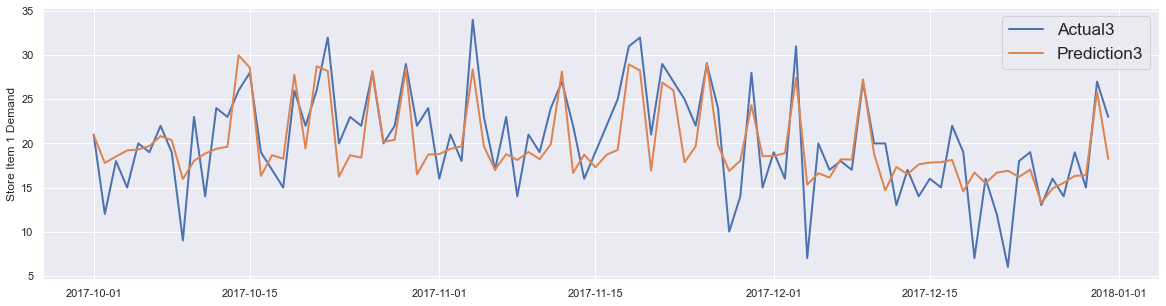

In [83]:
plt.figure(figsize = (20,5))
plt.plot(compare3['Actual3'], label = 'Actual3', linewidth = 2)
plt.plot(compare3['Predict3'], label = 'Prediction3', linewidth = 2)
plt.legend(fontsize = 'x-large')
plt.ylabel('Store Item 1 Demand')
plt.show()

In [84]:
print('SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,1,7)')
regPrintErr(compare3['Actual3'],compare3['Predict3'])

SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)
R2 Score: 0.5987620460116606
MAPE: 17.667287016738083
RMSE: 3.68891594893417


## Model Evaluation

## Evaluate the model using MSE and RMSE

In [70]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
# Evaluation metrics
# MAPE mean_absolute_percentage_error
def regMAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1.))) * 100


# print_error
def regPrintErr(y_true, y_pred):
    print('R2 Score: {}'.format(r2_score(y_true, y_pred)))
    print('MAPE: {}'.format(regMAPE(y_true, y_pred)))
    print('RMSE: {}'.format(sqrt(mean_squared_error(y_true, y_pred))))

In [102]:
#order = (1,0,0), seasonal_order = (0,1,1,7)
print('SARIMA: Weekly Seasonality')
regPrintErr(test, predict1)

SARIMA: Weekly Seasonality
R2 Score: -0.5702275537435224
MAPE: 36.48551255946151
RMSE: 7.297583171849058


In [106]:
print('SARIMA: Weekly Seasonality')
regPrintErr(test, predict1)

SARIMA: Weekly Seasonality
R2 Score: -0.4292802725175622
MAPE: 35.67291767988715
RMSE: 6.962359691586313


In [116]:
print('SARIMA: yearly Seasonality')
regPrintErr(test, predict_365['predict'])

SARIMA: yearly Seasonality
R2 Score: -0.498903138694649
MAPE: 31.51101769552177
RMSE: 7.1299180957627994


In [117]:
# Seasonality (4,1,1), seasonal_order = (1,0,2,7)
print('SARIMAX: Includes Both Weekly and Yearly')
regPrintErr(test, predict_exog2)

SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)
R2 Score: 0.2662052014750729
MAPE: 22.904606544876692
RMSE: 4.9886733837936275


In [126]:
###BEST
# (4,1,1), seasonal_order = (1,0,1,7)
print('SARIMAX - Walk-Forward')
regPrintErr(compare3['Actual3'], compare3['Predict3'])

SARIMAX - Walk-Forward
R2 Score: 0.3280446641385626
MAPE: 22.39444878562704
RMSE: 4.773841108255746


In [135]:
results = {'Actual': test.values, 'SARIMA (weekly)':predict1, 
         'SARIMA (Yearly)': predict_365['predict'], 'SARIMAX_wy_Fourier': predict_exog2, 'SARIMAX (Walk-Forward)': compare3['Predict3']}

In [133]:
test

date
2017-10-01    21
2017-10-02    12
2017-10-03    18
2017-10-04    15
2017-10-05    20
              ..
2017-12-27    14
2017-12-28    19
2017-12-29    15
2017-12-30    27
2017-12-31    23
Name: sales, Length: 92, dtype: int64

In [134]:
predict1

2017-10-01    28.163247
2017-10-02    19.857715
2017-10-03    22.623073
2017-10-04    23.417735
2017-10-05    24.080831
                ...    
2017-12-27    24.026573
2017-12-28    24.651830
2017-12-29    26.362679
2017-12-30    28.183077
2017-12-31    28.946897
Freq: D, Length: 92, dtype: float64

In [1]:
#results

In [128]:
results_SARIMA = pd.DataFrame(results)

In [129]:
results_SARIMA.head()

,Actual,SARIMA (weekly),SARIMA (Yearly),SARIMAX_wy_Fourier,SARIMAX (Walk-Forward)
2017-10-01,21,28.163247,24.846157,26.925491,27.200808
2017-10-02,12,19.857715,26.003381,18.200592,17.970798
2017-10-03,18,22.623073,19.999926,20.933126,20.664465
2017-10-04,15,23.417735,28.000002,22.454429,21.610142
2017-10-05,20,24.080831,17.000000,23.091248,21.751867


In [130]:
results_SARIMA.to_csv('results_SARIMA.csv')